![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Machine Learning Methods </center>
## <center> Non-negative Matrix Factorization (NMF)</center>
### <center> NMF for Recommendation Systems </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/MachineLearningMethod/22_NMF/MainRecSystems.ipynb)

In [1]:
import numpy             as np
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

### Loading the data
https://grouplens.org/datasets/movielens/  
http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [2]:
dData         = pd.read_csv('./ml-latest-small/ratings.csv')
dData.columns = ['UserID', 'MovieID', 'Rating', 'TimeStamp']
dData

,UserID,MovieID,Rating,TimeStamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


#### The list of movies:

In [3]:
dMovies         = pd.read_csv('./ml-latest-small/movies.csv')
dMovies.columns = ['MovieID', 'Title', 'Genres']
dMovies[:10]

,MovieID,Title,Genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


#### Filter
We filter out:
1. Movies with less than 20 ratings (by different users)
2. Users with less than 20 ratings (of different movies)

In [4]:
dData = dData.groupby('MovieID').filter(lambda x: x['MovieID'].count() >= 20)
dData = dData.groupby('UserID' ).filter(lambda x: x['UserID' ].count() >= 20)
dData

,UserID,MovieID,Rating,TimeStamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100803,610,148626,4.0,1493847175
100808,610,152081,4.0,1493846503
100829,610,164179,5.0,1493845631
100830,610,166528,4.0,1493879365


#### Replacing ID with index

In [5]:
vMovieID  = dData['MovieID'].unique()
vUserID   = dData['UserID' ].unique()
nMovies   = len(vMovieID)
nUsers    = len(vUserID)
vMovieIdx = range(nMovies)
vUserIdx  = range(nUsers)

dMovieID2Idx = dict(zip(vMovieID,  vMovieIdx))
dUserID2Idx  = dict(zip(vUserID,   vUserIdx))
dIdx2MovieID = dict(zip(vMovieIdx, vMovieID ))
dIdx2UserID  = dict(zip(vUserIdx,  vUserID ))

dData2         = dData.copy()
dData2.columns = ['UserIdx', 'MovieIdx', 'Rating', 'TimeStamp']
dData2['UserIdx'] .replace(dUserID2Idx,  inplace=True)
dData2['MovieIdx'].replace(dMovieID2Idx, inplace=True)
dData2

,UserIdx,MovieIdx,Rating,TimeStamp
0,0,0,4.0,964982703
1,0,1,4.0,964981247
2,0,2,4.0,964982224
3,0,3,5.0,964983815
4,0,4,5.0,964982931
...,...,...,...,...
100803,565,823,4.0,1493847175
100808,565,652,4.0,1493846503
100829,565,824,5.0,1493845631
100830,565,653,4.0,1493879365


#### Some useful functions:

In [6]:
def ID2Name(vID):
    return [dMovies[dMovies['MovieID'] == ID]['Title'].values[0][:-7] for ID in vID]
    
def Idx2ID(vIdx):
    return [dIdx2MovieID[idx] for idx in vIdx]

def Idx2Name(vIdx):
    return ID2Name(Idx2ID(vIdx))

vIdx = range(10)
list(zip(vIdx, Idx2ID(vIdx), Idx2Name(vIdx)))

[(0, 1, 'Toy Story'),
 (1, 3, 'Grumpier Old Men'),
 (2, 6, 'Heat'),
 (3, 47, 'Seven (a.k.a. Se7en)'),
 (4, 50, 'Usual Suspects, The'),
 (5, 70, 'From Dusk Till Dawn'),
 (6, 101, 'Bottle Rocket'),
 (7, 110, 'Braveheart'),
 (8, 151, 'Rob Roy'),
 (9, 163, 'Desperado')]

### Building the matrices:
1. `mX` is the `[User]x[Movie]` matrix.
2. `mM` is the mask matrix

In [7]:
from scipy.sparse import coo_matrix

vUsers  = dData2['UserIdx' ].values
vMoives = dData2['MovieIdx'].values
vRate   = dData2['Rating'  ].values

mX      = coo_matrix((vRate,     (vUsers, vMoives)), shape=(nUsers, nMovies))
mM      = coo_matrix((0*vRate+1, (vUsers, vMoives)), shape=(nUsers, nMovies))
mX

<566x1297 sparse matrix of type '<class 'numpy.float64'>'
	with 67225 stored elements in COOrdinate format>

In [8]:
mX.size / np.prod(mX.shape)

0.09157446785324111

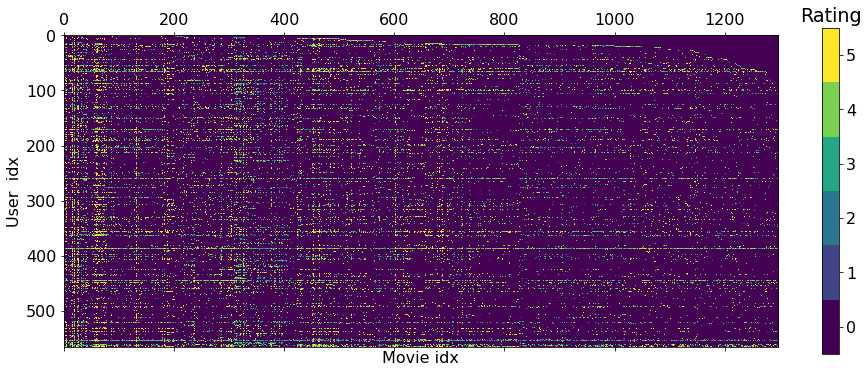

In [9]:
from matplotlib.cm import get_cmap

_, ax = plt.subplots(figsize=(16, 6))

h = ax.matshow(mX.todense(), cmap=get_cmap('viridis', 6), vmin=-1/2, vmax=5.5)
ax.set_xlabel ('Movie idx')
ax.set_ylabel ('User  idx')
plt.colorbar  (h, ax=ax).ax.set_title('Rating')
plt.show      ()

### NMF:

In [10]:
import time
from numpy.linalg import norm

def NMF(mX, mW, mH, mM, numIter=50):
    
    vT      = np.full(numIter, np.nan)
    vErr    = np.full(numIter, np.nan)
    vErr[0] = norm(mX - mM.multiply(mW @ mH).todense())
    vT  [0] = time.time()
    for ii in range(1, numIter):
        print(f'\rIteration: {numIter - ii:04}', end='')
        mH = mH * ((mW.T @ mX)   / (mW.T @ mM.multiply(mW @ mH) + 1e-10))
        mW = mW * ((mX   @ mH.T) / (mM.multiply(mW @ mH) @ mH.T + 1e-10))
            
        vErr[ii] = norm(mX - mM.multiply(mW @ mH).todense())
        vT  [ii] = time.time()
            
    return mW, mH, vErr, vT - vT[0]

#### Apply NMD:

Iteration: 0001

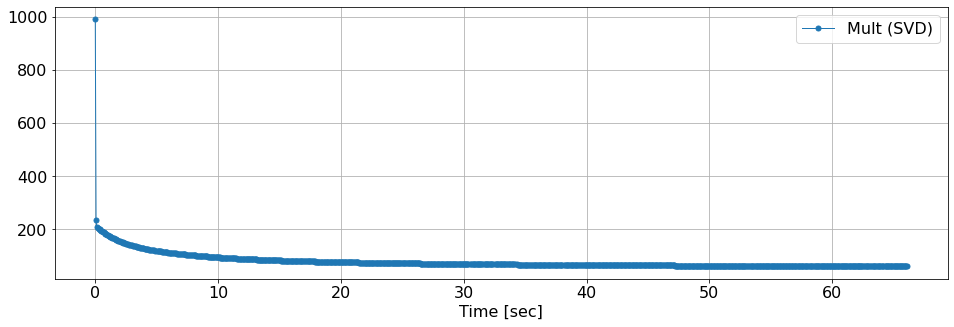

In [11]:
from scipy.sparse.linalg import svds

d                = 50
[mW0, vS, mH0]   = svds(mX, d)
mW0              = mW0 * np.sqrt(vS)
mH0              = mH0 * np.sqrt(vS[:,None])
mW0              = np.abs(mW0)
mH0              = np.abs(mH0)
mW, mH, vErr, vT = NMF(mX, mW0, mH0, mM, numIter=1000)

plt.figure(figsize=(16, 5))
plt.plot  (vT, vErr, lw=1, marker='.', ms=10, label='Mult (SVD)')
plt.xlabel('Time [sec]')
plt.legend()
plt.grid  ()
plt.show  ()

In [12]:
mX.shape, mW.shape, mH.shape

((566, 1297), (566, 50), (50, 1297))

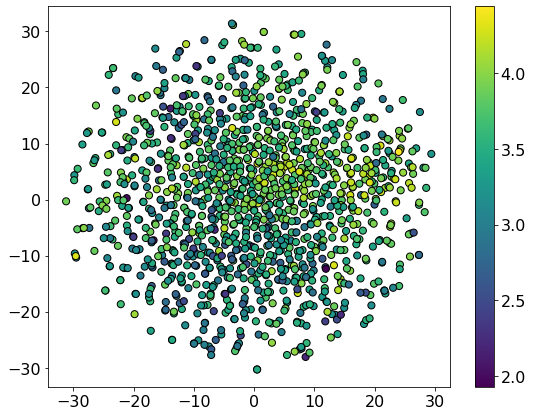

In [13]:
from sklearn.manifold import TSNE

vY = dData2.groupby('MovieIdx').mean()['Rating'].values
mZ = TSNE(n_components=2).fit_transform(mH.T)

plt.figure  (figsize=(9, 7))
plt.scatter (*mZ.T, c=vY, s=50, edgecolor='k')
plt.colorbar()
plt.show    ()

#### Apply Clustering to the movies (`mH`)

In [14]:
from sklearn.cluster import KMeans

vC = KMeans(n_clusters=10).fit_predict(mH.T)

In [15]:
vNames = np.array(Idx2Name(range(nMovies)))
vNames[:5]

array(['Toy Story', 'Grumpier Old Men', 'Heat', 'Seven (a.k.a. Se7en)',
       'Usual Suspects, The'], dtype='<U87')

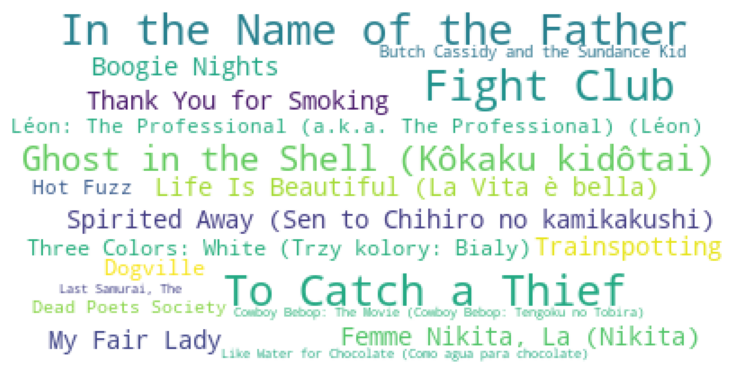

In [16]:
from wordcloud import WordCloud

idx       = 0
vIdx      = np.where(vC == idx)[0]
Dict      = dict(zip(vNames[vIdx], vY[vIdx]))
wordcloud = WordCloud(background_color='white', max_words=20).generate_from_frequencies(Dict) 

plt.figure      (figsize=(10, 8)) 
plt.imshow      (wordcloud) 
plt.axis        ('off') 
plt.tight_layout(pad=0) 
plt.show        () 

### Exercise
Given the NMF decomposition $\boldsymbol{X}=\boldsymbol{W}\boldsymbol{H}$,  
write a script that provides the top $5$ movie suggestions to user `idx`.<br>
You must suggest **unseen** movies.

In [17]:
idx = np.random.randint(nUsers)
vX  = mX.getrow(idx).toarray()[0,:]
vX.shape

(1297,)

#### Top 5 seen movies:

['Lion King, The',
 'Requiem for a Dream',
 'Black Swan',
 'Notebook, The',
 'Exorcist, The']

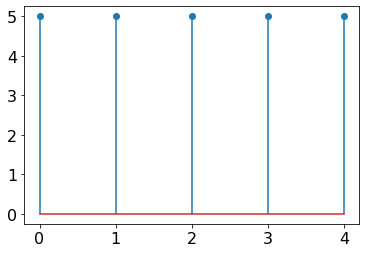

In [18]:
K    = 5
vIdx = np.argsort(-vX)[:K]
plt.stem(vX[vIdx])
Idx2Name(vIdx)

#### 5 unseen movies suggestions:
Use `mW` and `mH`...

In [19]:
???

Object `?` not found.


In [20]:
# mHatX   = (mW @ mH) * mM.toarray()
# vHatX   = mHatX[idx,:]
# vHatIdx = np.argsort(-vHatX)[:K]
# plt.stem(vX[vHatIdx])
# Idx2Name(vHatIdx)

In [21]:
# mHatX   = (mW @ mH) * (1 - mM.toarray())
# vHatX   = mHatX[idx,:]
# vHatIdx = np.argsort(-vHatX)[:K]
# plt.stem(vHatX[vHatIdx])
# Idx2Name(vHatIdx)